In [1]:
import numpy as np
import pandas as pd
import os
from numpy.random import seed
from tensorflow.random import set_seed
set_seed(42)
seed(42)
os.environ['PYTHONHASHSEED']=str(42)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models
import multiprocessing
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt
import cloudpickle

In [2]:
# data source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
def get_data(path: str="data/DOM_hourly.csv"):
    '''
    Read data from specified path, parse date column and set it as index to the dataframe
    '''
    data = pd.read_csv(path)
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.sort_values("Datetime", inplace=True)
    data.set_index('Datetime', inplace=True)
    data = data['DOM_MW'].copy()
    data.fillna(method="ffill")
    return data

In [3]:
def train_val_test_split(data, val_test_size):
    '''
    split the data into train,val and test sets
    '''
    x_train, x_val, x_test = (data[:-(val_test_size * 2)].copy(),
                              data[-(val_test_size * 2):-val_test_size].copy(),
                              data[-val_test_size:].copy())
    return x_train, x_val, x_test

In [4]:
data = get_data()
x_train, x_val, x_test = train_val_test_split(data, val_test_size=10000)

In [5]:
x_train

Datetime
2005-05-01 01:00:00    7190.0
2005-05-01 02:00:00    6803.0
2005-05-01 03:00:00    6583.0
2005-05-01 04:00:00    6452.0
2005-05-01 05:00:00    6445.0
                        ...  
2016-04-21 12:00:00    9528.0
2016-04-21 13:00:00    9544.0
2016-04-21 14:00:00    9652.0
2016-04-21 15:00:00    9824.0
2016-04-21 16:00:00    9892.0
Name: DOM_MW, Length: 96189, dtype: float64

In [6]:
x_val

Datetime
2016-04-21 17:00:00     9980.0
2016-04-21 18:00:00    10076.0
2016-04-21 19:00:00    10074.0
2016-04-21 20:00:00    10263.0
2016-04-21 21:00:00    10590.0
                        ...   
2017-06-12 04:00:00     9342.0
2017-06-12 05:00:00     9368.0
2017-06-12 06:00:00     9706.0
2017-06-12 07:00:00    10452.0
2017-06-12 08:00:00    11415.0
Name: DOM_MW, Length: 10000, dtype: float64

In [7]:
x_test

Datetime
2017-06-12 09:00:00    12349.0
2017-06-12 10:00:00    13321.0
2017-06-12 11:00:00    14294.0
2017-06-12 12:00:00    15165.0
2017-06-12 13:00:00    15871.0
                        ...   
2018-08-02 20:00:00    14038.0
2018-08-02 21:00:00    13832.0
2018-08-02 22:00:00    13312.0
2018-08-02 23:00:00    12390.0
2018-08-03 00:00:00    11385.0
Name: DOM_MW, Length: 10000, dtype: float64

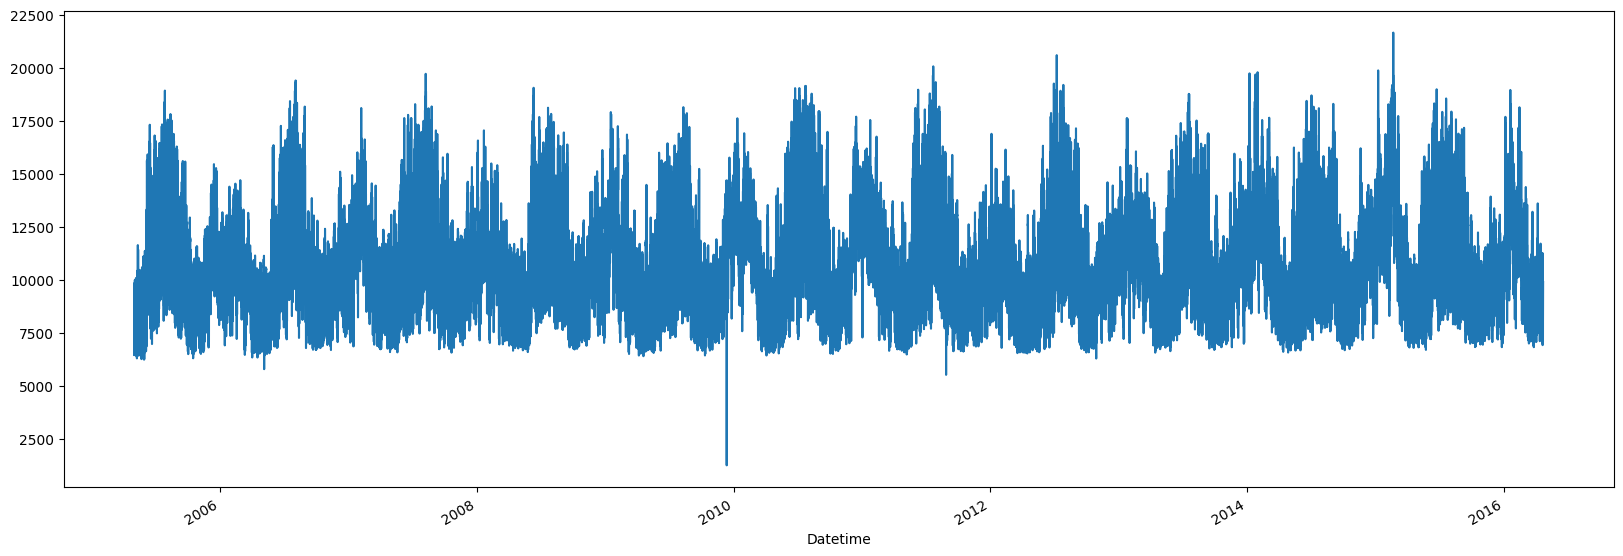

In [8]:
x_train.plot(figsize=(20, 7));

In [9]:
def scale_data(x_train, x_val, x_test):
    '''
    Scale x_train, x_val andx_test data sets
    '''
    x_train, x_val, x_test = (x_train.values.reshape(-1, 1).copy(), 
                              x_val.values.reshape(-1, 1).copy(),
                              x_test.values.reshape(-1, 1).copy())
    
    
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train).ravel()
    x_val=scaler.transform(x_val).ravel()
    x_test=scaler.transform(x_test).ravel()
    
    return x_train, x_val, x_test, scaler

In [10]:
x_train, x_val, x_test, scaler = scale_data(x_train, x_val, x_test)

In [11]:
x_train

array([0.29105795, 0.2720855 , 0.26130013, ..., 0.41175605, 0.42018825,
       0.42352191])

In [12]:
# function that runs parallely to generate data sequences 
def sub_arr(arr, strt, end):
    arr = arr.copy()
    return arr[strt:end]

In [13]:
def prepare_data_sequences(x, seq_len):
    '''
    Prepare sequences having length = seq_len 
    x_ = [x_1, x_2,....x_seq_len]
    y_ = [y_(seq_len + 1)]
    '''
    p = 0
    seq_len += 1
    res = np.array([])
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    results = []
     
    while p <= len(x) - seq_len:
        f = pool.apply_async(sub_arr, args=(x, p, (p + seq_len)))
        results.append(f)
        p+=1
        
    for n, f in enumerate(results):
        if n == 0: 
            pool.close()
            pool.join()
            res = f.get(timeout=120)
        else:
            res = np.vstack([res, f.get(timeout=120)])
    
    y_ = res[:, -1]
    x_ = res[:, :-1]
    x_ = x_.reshape(len(x_), -1, 1)
    return x_, y_

In [14]:
SEQ_LEN = 20 # Randomly assigned to 20. It is a hyperparameter that must be tuned.

In [15]:
x_train, y_train = prepare_data_sequences(x_train, seq_len=SEQ_LEN)

In [16]:
x_train.shape, y_train.shape

((96169, 20, 1), (96169,))

In [17]:
x_train[0]

array([[0.29105795],
       [0.2720855 ],
       [0.26130013],
       [0.25487793],
       [0.25453476],
       [0.25899598],
       [0.26713403],
       [0.28845965],
       [0.31816845],
       [0.34130797],
       [0.34954407],
       [0.35013237],
       [0.35042651],
       [0.34586724],
       [0.33988626],
       [0.33748407],
       [0.34081773],
       [0.34542602],
       [0.35165212],
       [0.35974115]])

In [18]:
x_train[-1]

array([[0.42896362],
       [0.43141484],
       [0.41719776],
       [0.37616433],
       [0.32454162],
       [0.30703991],
       [0.29365624],
       [0.28890087],
       [0.28556721],
       [0.2993921 ],
       [0.33380724],
       [0.38822434],
       [0.40954996],
       [0.41053044],
       [0.40959898],
       [0.40719678],
       [0.40567703],
       [0.40646142],
       [0.41175605],
       [0.42018825]])

In [19]:
y_train

array([0.39258751, 0.38018433, 0.34439651, ..., 0.41175605, 0.42018825,
       0.42352191])

In [20]:
x_val, y_val = prepare_data_sequences(x_val, seq_len=SEQ_LEN)
x_val.shape, y_val.shape

((9980, 20, 1), (9980,))

In [21]:
x_test, y_test = prepare_data_sequences(x_test, seq_len=SEQ_LEN)
x_test.shape, y_test.shape

((9980, 20, 1), (9980,))

In [22]:
print(x_test[-1])
print(y_test[-1])

[[0.43283655]
 [0.43165997]
 [0.45283851]
 [0.48671438]
 [0.51951172]
 [0.55407393]
 [0.58726346]
 [0.62324738]
 [0.65756447]
 [0.68330228]
 [0.68590058]
 [0.67104618]
 [0.66369252]
 [0.67021277]
 [0.66893813]
 [0.64712227]
 [0.62677714]
 [0.61667811]
 [0.59118541]
 [0.5459849 ]]
0.4967153642513972


In [23]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [24]:
def train_model(model, x_train, y_train, x_val, y_val, batch_size=200, epochs=200, patience=5):
    early_stop = EarlyStopping(monitor="val_loss", patience=patience)
    model.fit(x_train, y_train, epochs=200, verbose=2, validation_data=(x_val, y_val), callbacks=[early_stop], batch_size=200)
    return model

In [25]:
model = build_model(input_shape=(x_train.shape[1], 1))
model = train_model(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=200)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 batch_normalization (BatchN  (None, 20, 32)           128       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 32)           128       
 hNormalization)                                        

In [26]:
def get_predictions(model, scaler, x):
    '''
    Returns predictions in the original scale
    '''
    scaled_predictions = model.predict(x).ravel()
    predictions = scaler.inverse_transform([scaled_predictions]).ravel()
    return predictions

In [27]:
get_predictions(model, scaler, x_train)

3006/3006 [==============================] - 11s 3ms/step


array([ 8775.85624766,  9631.70589155,  8798.6515733 , ...,
        9610.29598773,  9834.48082381, 10093.44163191])

In [28]:
def evaluate_model(model, scaler, x, scaled_y, dataset="test"):
    '''
    Evaluates the model using r2 score and RMSE on predictions in the original scale
    '''
    predictions = get_predictions(model, scaler, x)
    y = scaler.inverse_transform([scaled_y]).ravel()
    r2 = r2_score(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    fig = plt.figure(figsize=(20, 7))
    plt.plot(y, label="Actual", color="green", alpha=0.7)
    plt.plot(predictions, label="Predictions", color="red", alpha=0.5)
    plt.title(f"Actuals Vs Predictions ({dataset}) data")
    plt.legend()
    plt.show()
    print(f"{dataset} RMSE: {rmse}\n{dataset} R2: {r2}")

3006/3006 [==============================] - 10s 3ms/step


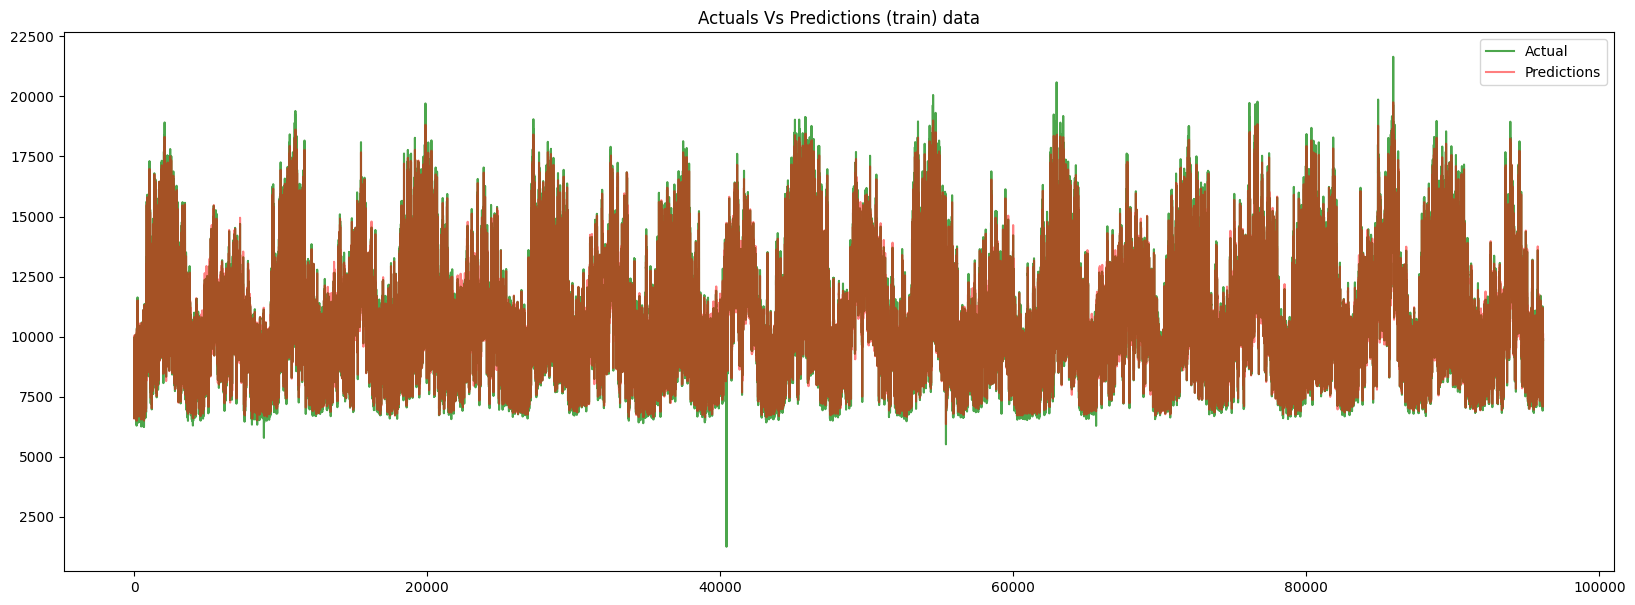

train RMSE: 241.13642842811095
train R2: 0.9898041986899685


In [29]:
evaluate_model(model, scaler, x_train, y_train, dataset='train')

312/312 [==============================] - 1s 3ms/step


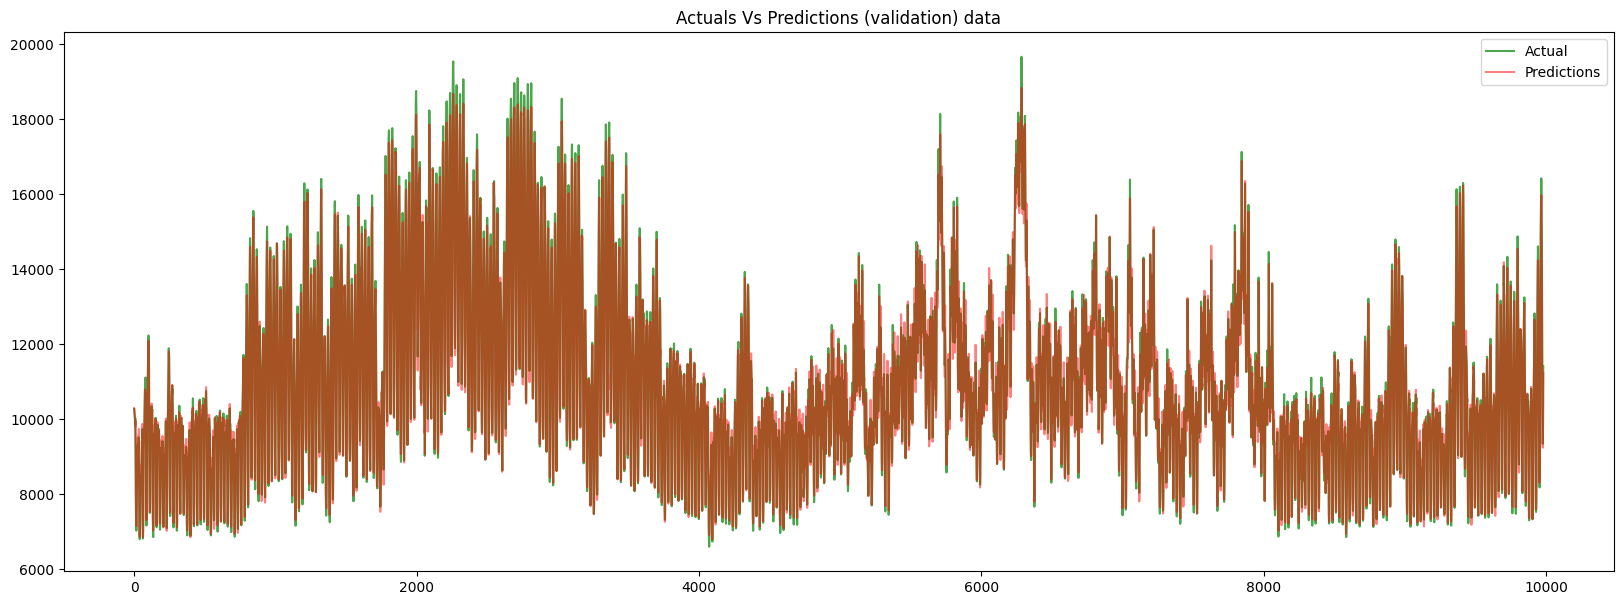

validation RMSE: 226.19935869733766
validation R2: 0.9913833713532125


In [30]:
evaluate_model(model, scaler, x_val, y_val, dataset='validation')

312/312 [==============================] - 1s 3ms/step


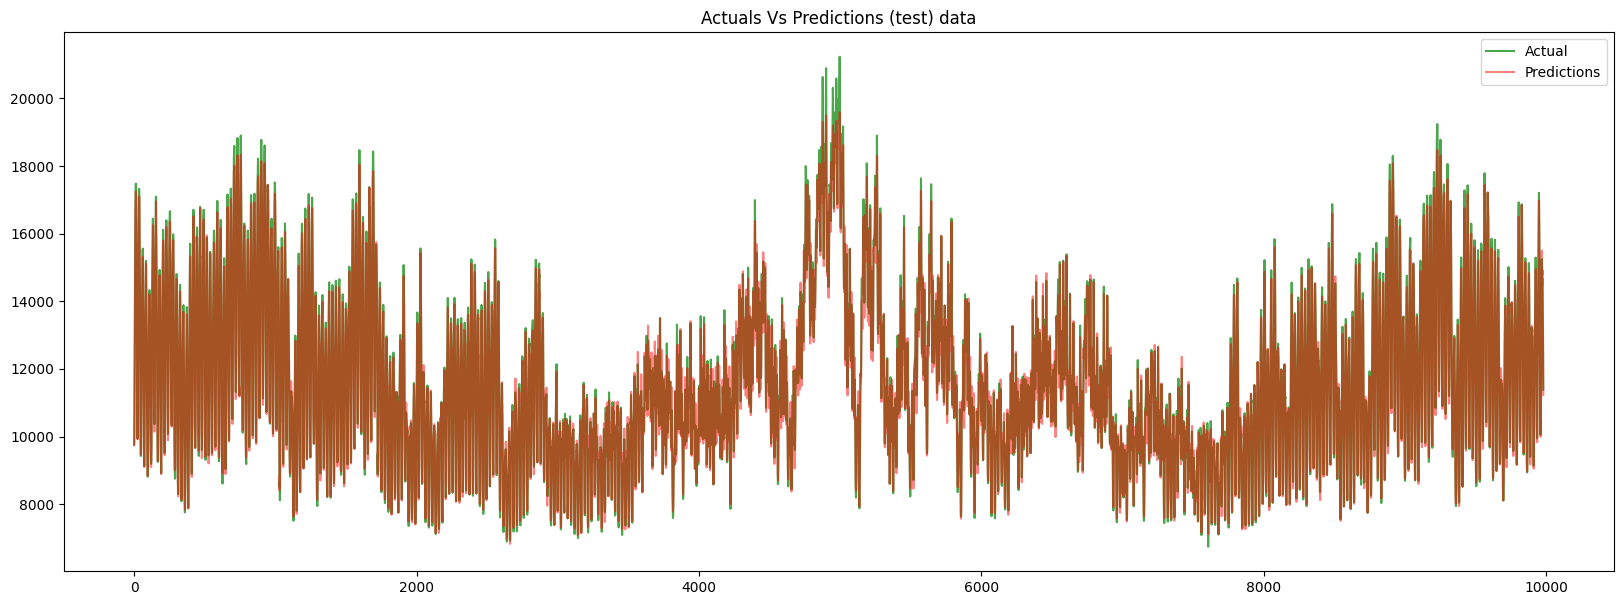

test RMSE: 244.9003531225592
test R2: 0.9906365296047817


In [31]:
evaluate_model(model, scaler, x_test, y_test, dataset='test')

### Retraining model on train+val set

In [32]:
# Refitting the scaler again on the train+val set might result in a better performance.
# Avoiding that step to save execution time

In [33]:
x_val.shape, y_val.shape

((9980, 20, 1), (9980,))

In [34]:
x_train.shape, y_train.shape

((96169, 20, 1), (96169,))

In [35]:
x_train_val = np.vstack([x_train, x_val]).copy() # appending x_val to x_train
x_train_val.shape

(106149, 20, 1)

In [36]:
y_train_val = np.append(y_train, y_val).copy()
y_train_val.shape

(106149,)

In [37]:
del(x_train, y_train, x_val, y_val)

In [38]:
model = build_model(input_shape=(x_train_val.shape[1], 1))
model = train_model(model, x_train_val, y_train_val, x_test, y_test, batch_size=32, epochs=200, patience=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 32)            4352      
                                                                 
 dropout_4 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 20, 32)            8320      
                                                                 
 dropout_5 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 32)           128       
 hNormalization)                                      

3318/3318 [==============================] - 12s 3ms/step


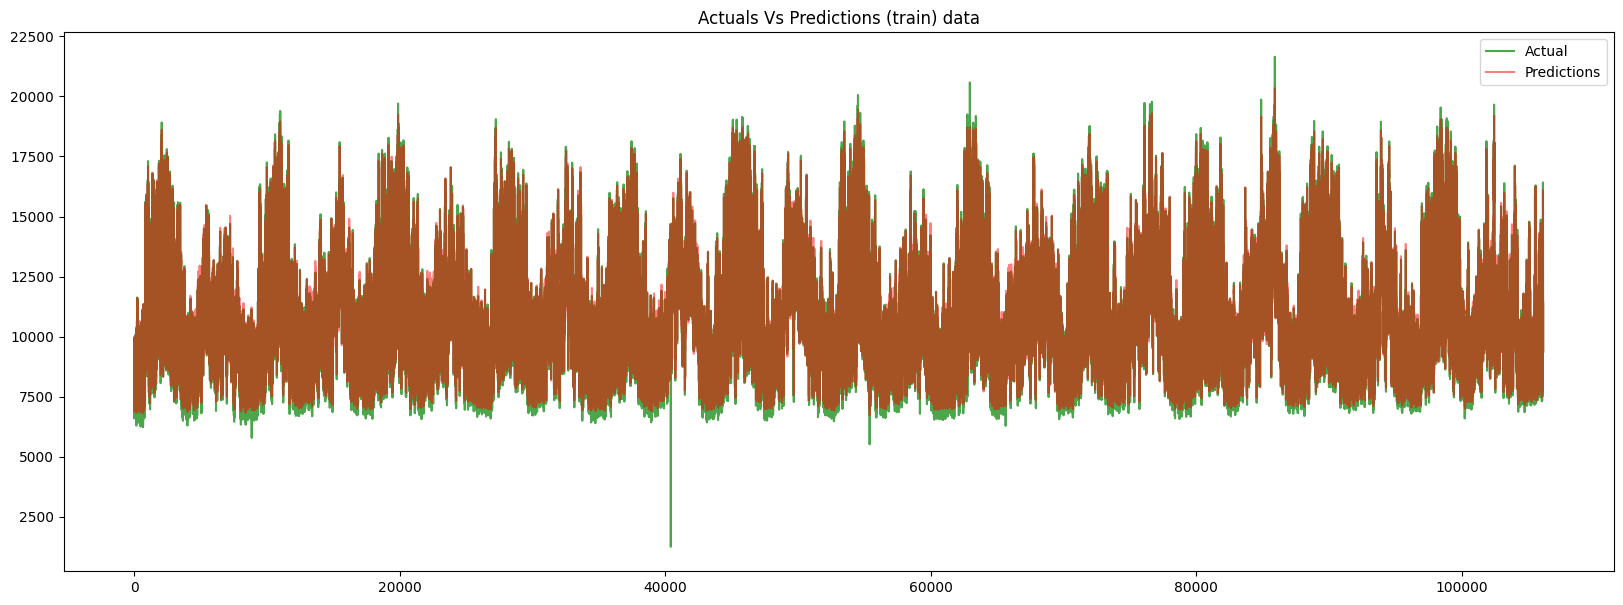

train RMSE: 220.41775014449468
train R2: 0.9915142052709204


In [39]:
evaluate_model(model, scaler, x_train_val, y_train_val, dataset='train')

312/312 [==============================] - 1s 4ms/step


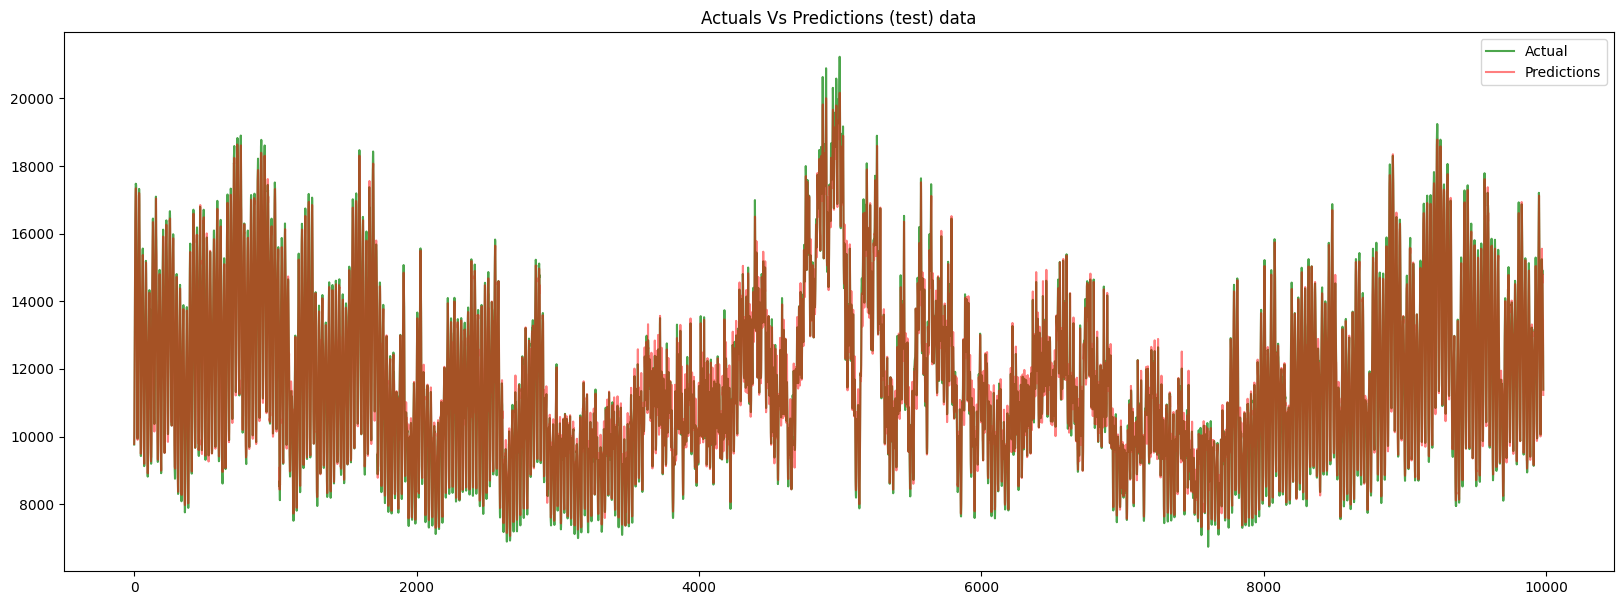

test RMSE: 211.98765475064192
test R2: 0.9929841683466636


In [40]:
evaluate_model(model, scaler, x_test, y_test, dataset='test')

## Save model

In [41]:
def save_model(model, scaler, seq_len, dir_path=os.path.join("models")):
    scaler_seqlen = (scaler, seq_len)
    with open(os.path.join(dir_path, 'scaler_seqlen.bin'), "wb") as f:
        cloudpickle.dump(scaler_seqlen, f)
    model.save(os.path.join(dir_path, "lstm_ts.h5"))
    print("Successfully saved the model")

In [42]:
save_model(model, scaler, SEQ_LEN)

Successfully saved the model


## INFERENCE

## Load saved model

In [43]:
def load_model(model_path=os.path.join("models", "lstm_ts.h5"),
               scaler_path=os.path.join("models", "scaler_seqlen.bin")):
    
    with open(scaler_path, "rb") as f:
        (scaler, SEQ_LEN) = cloudpickle.load(f)
    model = models.load_model(model_path)
    return (model, scaler, SEQ_LEN)

In [44]:
def get_data(path: str="data/DOM_hourly.csv"):
    data = pd.read_csv(path)
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data.sort_values("Datetime", inplace=True)
    data.set_index('Datetime', inplace=True)
    data = data['DOM_MW'].copy()
    data.fillna(method="ffill")
    return data

In [45]:
def scale_data(x, scaler):
    x = x.values.reshape(-1, 1).copy()
    x=scaler.transform(x).ravel()
    return x

In [46]:
def get_predictions(model, scaler, x):
    scaled_predictions = model.predict(x, verbose=False).ravel()
    predictions = scaler.inverse_transform([scaled_predictions]).ravel()
    return predictions

In [47]:
def generate_inference(data, n_steps=10):
    '''
    Generates n_steps predictions by considering recent SEQ_LEN timesteps
    '''
    (model, scaler, SEQ_LEN) = load_model()
    x_inference = data[-SEQ_LEN:].copy()
    for i in range(n_steps):
        x_inference_arr = x_inference[-SEQ_LEN:].copy()
        x_inference_arr = scale_data(x_inference_arr, scaler)
        x_inference_arr = x_inference_arr.reshape(1, 20, 1)
        prediction = get_predictions(model, scaler, x_inference_arr)
        prediction_series =  pd.Series(prediction, index=[x_inference.index[-1] + pd.DateOffset(hours=1)])
        x_inference = pd.concat([x_inference, prediction_series])
    predictions = x_inference[-n_steps:].copy()
    return predictions

## Plot Forecast

In [48]:
def plot_forecast(data, n_steps=10):
    inference = generate_inference(data, n_steps=n_steps)
    data.loc[data.index.year > 2017].plot(figsize=(20,6), alpha=0.5, label="Actual")
    inference.plot(color='green', label="Forecast")
    plt.legend()
    plt.show()

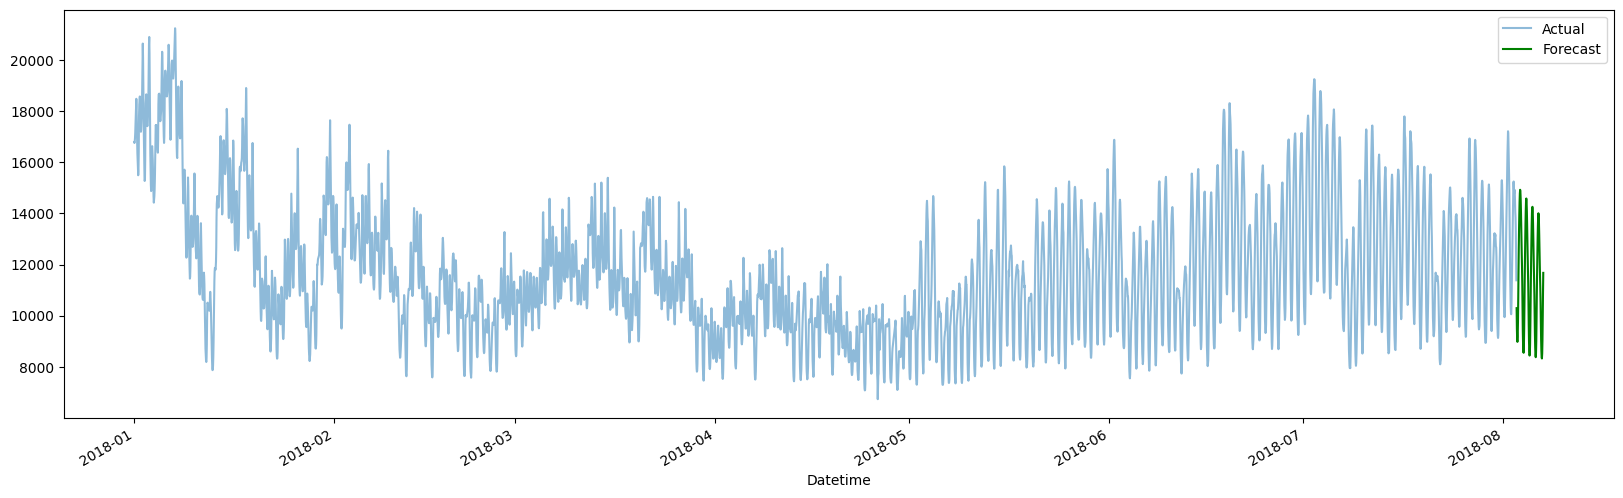

In [50]:
data = get_data()
# Forecast 100 time steps into the future using the previous SEQ_LEN=20 time steps
plot_forecast(data, n_steps=100) 